In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import keras
import tensorflow as tf

from statsmodels.nonparametric.smoothers_lowess import lowess
from numpy import array
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import metrics
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from keras.layers import Conv1D, MaxPooling1D, Flatten, InputLayer, Dense
from tensorflow.keras.layers import LeakyReLU, PReLU
from keras.models import Sequential

In [2]:
# Load the dataset
dataset = r"D:\Documents\MASTER OF DATA SCIENCE\Research Project\Dataset\FILTERED DATASET.xlsx"
df = pd.read_excel(dataset).reset_index(drop=True)
# df

In [3]:
# #Separate dates for future plotting
# train_dates = pd.to_datetime(df['Day'])

# # Include only numerical variables
# numeric_df = df.select_dtypes(include=['number']).drop(['Year'], axis='columns', inplace=False)

In [4]:
scaler = RobustScaler()
data_scaled = scaler.fit_transform(df)

In [5]:
features = data_scaled[:, 1:]
target = data_scaled[:,0]

In [6]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

# # Reshape the target
# y_train = y_train.reshape(len(y_train), 1)
# y_test = y_test.reshape(len(y_test), 1)

print(f'Train dataset shape: {x_train.shape}')
print(f'Target train dataset shape: {y_train.shape}')
print(f'Test dataset shape: {x_test.shape}')
print(f'Target test dataset shape: {y_test.shape}')

Train dataset shape: (1276, 7)
Target train dataset shape: (1276,)
Test dataset shape: (548, 7)
Target test dataset shape: (548,)


In [7]:
time_steps = 7
num_features = 7
batch_size = 32

train_generator = TimeseriesGenerator(x_train, y_train, length=time_steps, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=time_steps, sampling_rate=1, batch_size=batch_size)

In [8]:
initializer = tf.keras.initializers.HeUniform()

In [31]:
lstm_cnn = keras.models.Sequential(
    [
        # Input Layer
        keras.layers.InputLayer(shape=(time_steps, num_features), name='Input_layer'),
        
        # LSTM Layers
        keras.layers.LSTM(50, activation='relu',return_sequences=True, kernel_initializer=initializer, name='LSTM_Layer_1'),
        # keras.layers.LeakyReLU(),
        keras.layers.BatchNormalization(),
        
        # CNN Layers
        keras.layers.Conv1D(filters=16, activation='relu', kernel_size=3, padding='same', kernel_initializer=initializer, name='Convolutional_Layer_1'),
        # keras.layers.LeakyReLU(),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling1D(pool_size=2, strides=2, name='Max_Pooling_Layer_1'),
        keras.layers.Flatten(name='Flatten_Layer'),
        
        # Fully Connected Layer
        keras.layers.Dense(25, activation='relu',kernel_initializer=initializer, name='CNN_Fully_Connected_Layer_1'),
        # keras.layers.LeakyReLU(),
        keras.layers.BatchNormalization(),
        
        # Output Layer
        keras.layers.Dense(1, name='Output')
    ],
    name='Layers_CNNLSTM_Model'
)

In [32]:
lstm_cnn.summary()

Model: "Layers_CNNLSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_Layer_1 (LSTM)             │ (None, 7, 50)          │        11,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 7, 50)          │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Convolutional_Layer_1 (Conv1D)  │ (None, 7, 16)          │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 7, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_Pooling_Layer_1             │ (None, 3, 16)          │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Layer (Flatten)         │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CNN_Fully_Connected_Layer_1     │ (None, 25)             │         1,225 │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 25)             │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,631 (61.06 KB)

 Trainable params: 15,449 (60.35 KB)

 Non-trainable params: 182 (728.00 B)

In [33]:
lstm_cnn.save(r"D:\Documents\MASTER OF DATA SCIENCE\Research Project\Python Scripts\Model Training\lstm_cnn.h5")

In [12]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# lstm_cnn.to(device)

In [13]:
# # Create target variable (assuming you want to predict the next value)
# y_train = x_train[time_steps:]  # Use actual targets here
# y_test = x_test[time_steps:]     # Use actual targets here

In [14]:
# Compile the model
opt = keras.optimizers.SGD(learning_rate=0.001)
lstm_cnn.compile(optimizer=opt, loss="mse")

# Fit the model
epochs = 100
history = lstm_cnn.fit(train_generator, epochs=epochs, validation_data=test_generator, shuffle=False)

Epoch 1/100


c:\Users\User\anaconda3\envs\DSC790_DSProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.9726 - val_loss: 0.6478
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7580 - val_loss: 0.7410
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3514 - val_loss: 0.8005
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1469 - val_loss: 0.8335
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0205 - val_loss: 0.8491
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9316 - val_loss: 0.8528
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8660 - val_loss: 0.8516
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8147 - val_loss: 0.8508
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7742 - val_loss: 0.8509
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7409 - val_loss: 0.8506
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7130 - val_loss: 0.8488
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6892 - val_l

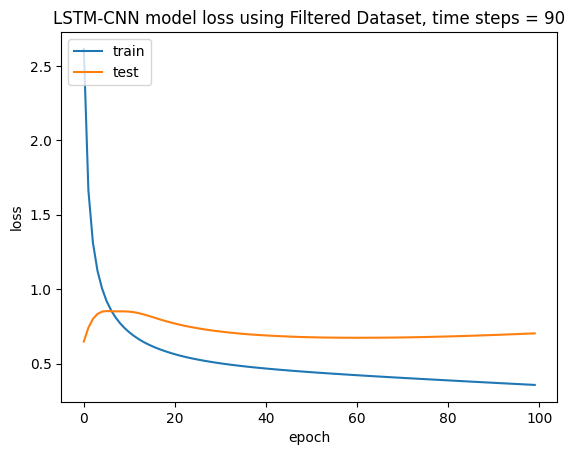

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM-CNN model loss using Filtered Dataset, time steps = 90')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
# Make predictions
predictions = lstm_cnn.predict(test_generator)  # Shape (n_samples, 1)

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(y_test - predictions))

# # Mean Absolute Percentage Error (MAPE), handling division by zero
# y_true_nonzero = np.where(y_test != 0, y_test, 1e-10)  # Replace zero with a small value
# mape = np.mean(np.abs((y_test - predictions) / y_true_nonzero)) * 100  # MAPE in percentage

#  Mean Squared Error (MSE)
mse = np.mean((y_test - predictions) ** 2)

# Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean((y_test - predictions) ** 2))

# Print metrics
print(f"Final Mean Absolute Error (MAE): {round(mae, 3)}")
print(f"Mean Squared Error (MSE): {round(mse, 3)}")
print(f"Final Root Mean Square Error (RMSE): {round(rmse, 3)}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Final Mean Absolute Error (MAE): 0.673
Mean Squared Error (MSE): 0.719
Final Root Mean Square Error (RMSE): 0.848


In [17]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[time_steps:])], axis=1)
rev_trans = scaler.inverse_transform(df_pred)

In [18]:
rev_trans

array([[ 5.75291200e+03,  2.15674000e+01,  2.42946000e+01, ...,
         8.63000000e-02, -3.70000000e-02,  9.54265000e+01],
       [ 9.01772788e+02,  2.16275000e+01,  2.47654000e+01, ...,
         5.56800000e-01,  1.74300000e-01,  9.53408000e+01],
       [ 1.60498081e+03,  2.11600000e+01,  2.31612000e+01, ...,
         7.53700000e-01,  2.22000000e-02,  9.53005000e+01],
       ...,
       [ 6.63301416e+03,  2.19514000e+01,  2.46012000e+01, ...,
         4.68400000e-01,  3.68300000e-01,  9.54044000e+01],
       [ 1.53756281e+03,  2.17002000e+01,  2.50197000e+01, ...,
         1.33500000e-01,  4.94000000e-01,  9.53686000e+01],
       [ 4.95879702e+03,  2.07236000e+01,  2.53824000e+01, ...,
        -7.72900000e-01, -5.19700000e-01,  9.53136000e+01]])

In [19]:
df_final = df[predictions.shape[0]*-1:]
df_final.count()

Power Generation (MW)                    541
Minimum Temperature (deg C)              541
Mean Temperature (deg C)                 541
Mean Dew Point Temperature (dec C)       541
Hargreaves Potential Evaporation (mm)    541
Eastward Wind Component (m/s)            541
Northward Wind Component (m/s)           541
Surface Pressure (kPa)                   541
dtype: int64

In [20]:
# Use .loc to explicitly assign values in the 'Forecasted Power Generation' column
df_final = df_final.copy()
df_final.loc[:, 'Forecasted Power Generation'] = rev_trans[:, 0]
# df_final

<Axes: title={'center': 'Hydropower Generation Forecasting using CNN-LSTM (Simplified)'}>

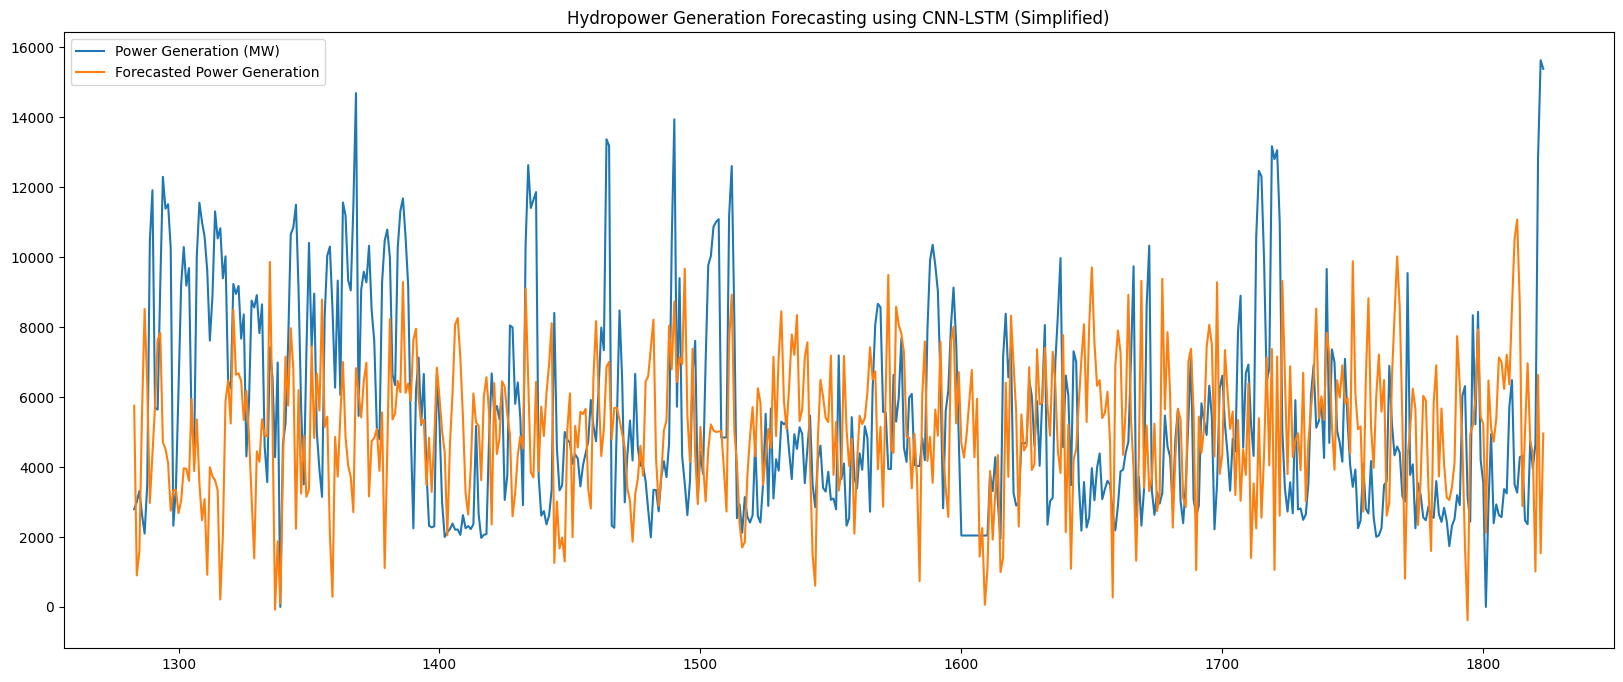

In [21]:
df_final[['Power Generation (MW)', 'Forecasted Power Generation']].plot(figsize=(20,8), title='Hydropower Generation Forecasting using CNN-LSTM (Simplified)')